In [1]:
import pandas as pd
import torch
from pathlib import Path
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from src.utils.metrics import event_detection_ap

from src.utils.post_process import post_process_for_seg
import jupyter_black
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


jupyter_black.load()
plt.style.use("ggplot")

EXP_NAME = "exp009_diffz_cnn"
RUN_NAME = "single"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [2]:
cfg = load_config(RESULT_DIR)
preds = np.load(RESULT_DIR / "preds_fold_0.npy")
labels = np.load(RESULT_DIR / "labels_fold_0.npy")
keys = np.load(RESULT_DIR / "keys_fold_0.npy")

gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

/tmp/ipykernel_873413/606133819.py:31: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [3]:
def objective(trial: optuna.Trial):
    score_th = trial.suggest_float("score_th", 0.0005, 0.1)
    distance = trial.suggest_int("distance", 20, 200)

    # pred_df: pl.DataFrame = post_process_for_seg(
    #     keys, preds[:, :, [1, 2]], score_th=score_th, distance=distance
    # )
    pred_df: pl.DataFrame = post_process_for_seg(keys, preds, score_th=score_th, distance=distance)
    score = event_detection_ap(gt_df, pred_df.to_pandas())

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2023-11-26 12:53:02,225] A new study created in memory with name: no-name-3b875ccf-455d-4821-8397-189774fc1249
[I 2023-11-26 12:53:05,890] Trial 0 finished with value: 0.7513606650195911 and parameters: {'score_th': 0.0181757907828261, 'distance': 127}. Best is trial 0 with value: 0.7513606650195911.
[I 2023-11-26 12:53:10,106] Trial 1 finished with value: 0.7508931065126323 and parameters: {'score_th': 0.01311208686933095, 'distance': 27}. Best is trial 0 with value: 0.7513606650195911.
[I 2023-11-26 12:53:13,439] Trial 2 finished with value: 0.7454444822059765 and parameters: {'score_th': 0.052701895799931946, 'distance': 109}. Best is trial 0 with value: 0.7513606650195911.
[I 2023-11-26 12:53:16,784] Trial 3 finished with value: 0.744240466795957 and parameters: {'score_th': 0.06299304736773534, 'distance': 74}. Best is trial 0 with value: 0.7513606650195911.
[I 2023-11-26 12:53:23,752] Trial 4 finished with value: 0.7526058301772125 and parameters: {'score_th': 0.00307804656967

{'score_th': 0.0005453716470894596, 'distance': 79}


In [4]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        # this_series_preds = preds[series_idx].reshape(-1, 3)
        # this_series_labels = labels[series_idx].reshape(-1, 3)
        this_series_preds = preds[series_idx].reshape(-1, 2)
        this_series_labels = labels[series_idx].reshape(-1, 2)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 0])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]

            # axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_wakeup")
            axs[j].vlines(
                onset_idx, 0, 1, label="onset", linestyles="dashed", color="orange", alpha=0.5
            )
            axs[j].vlines(
                wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="green", alpha=0.5
            )
            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

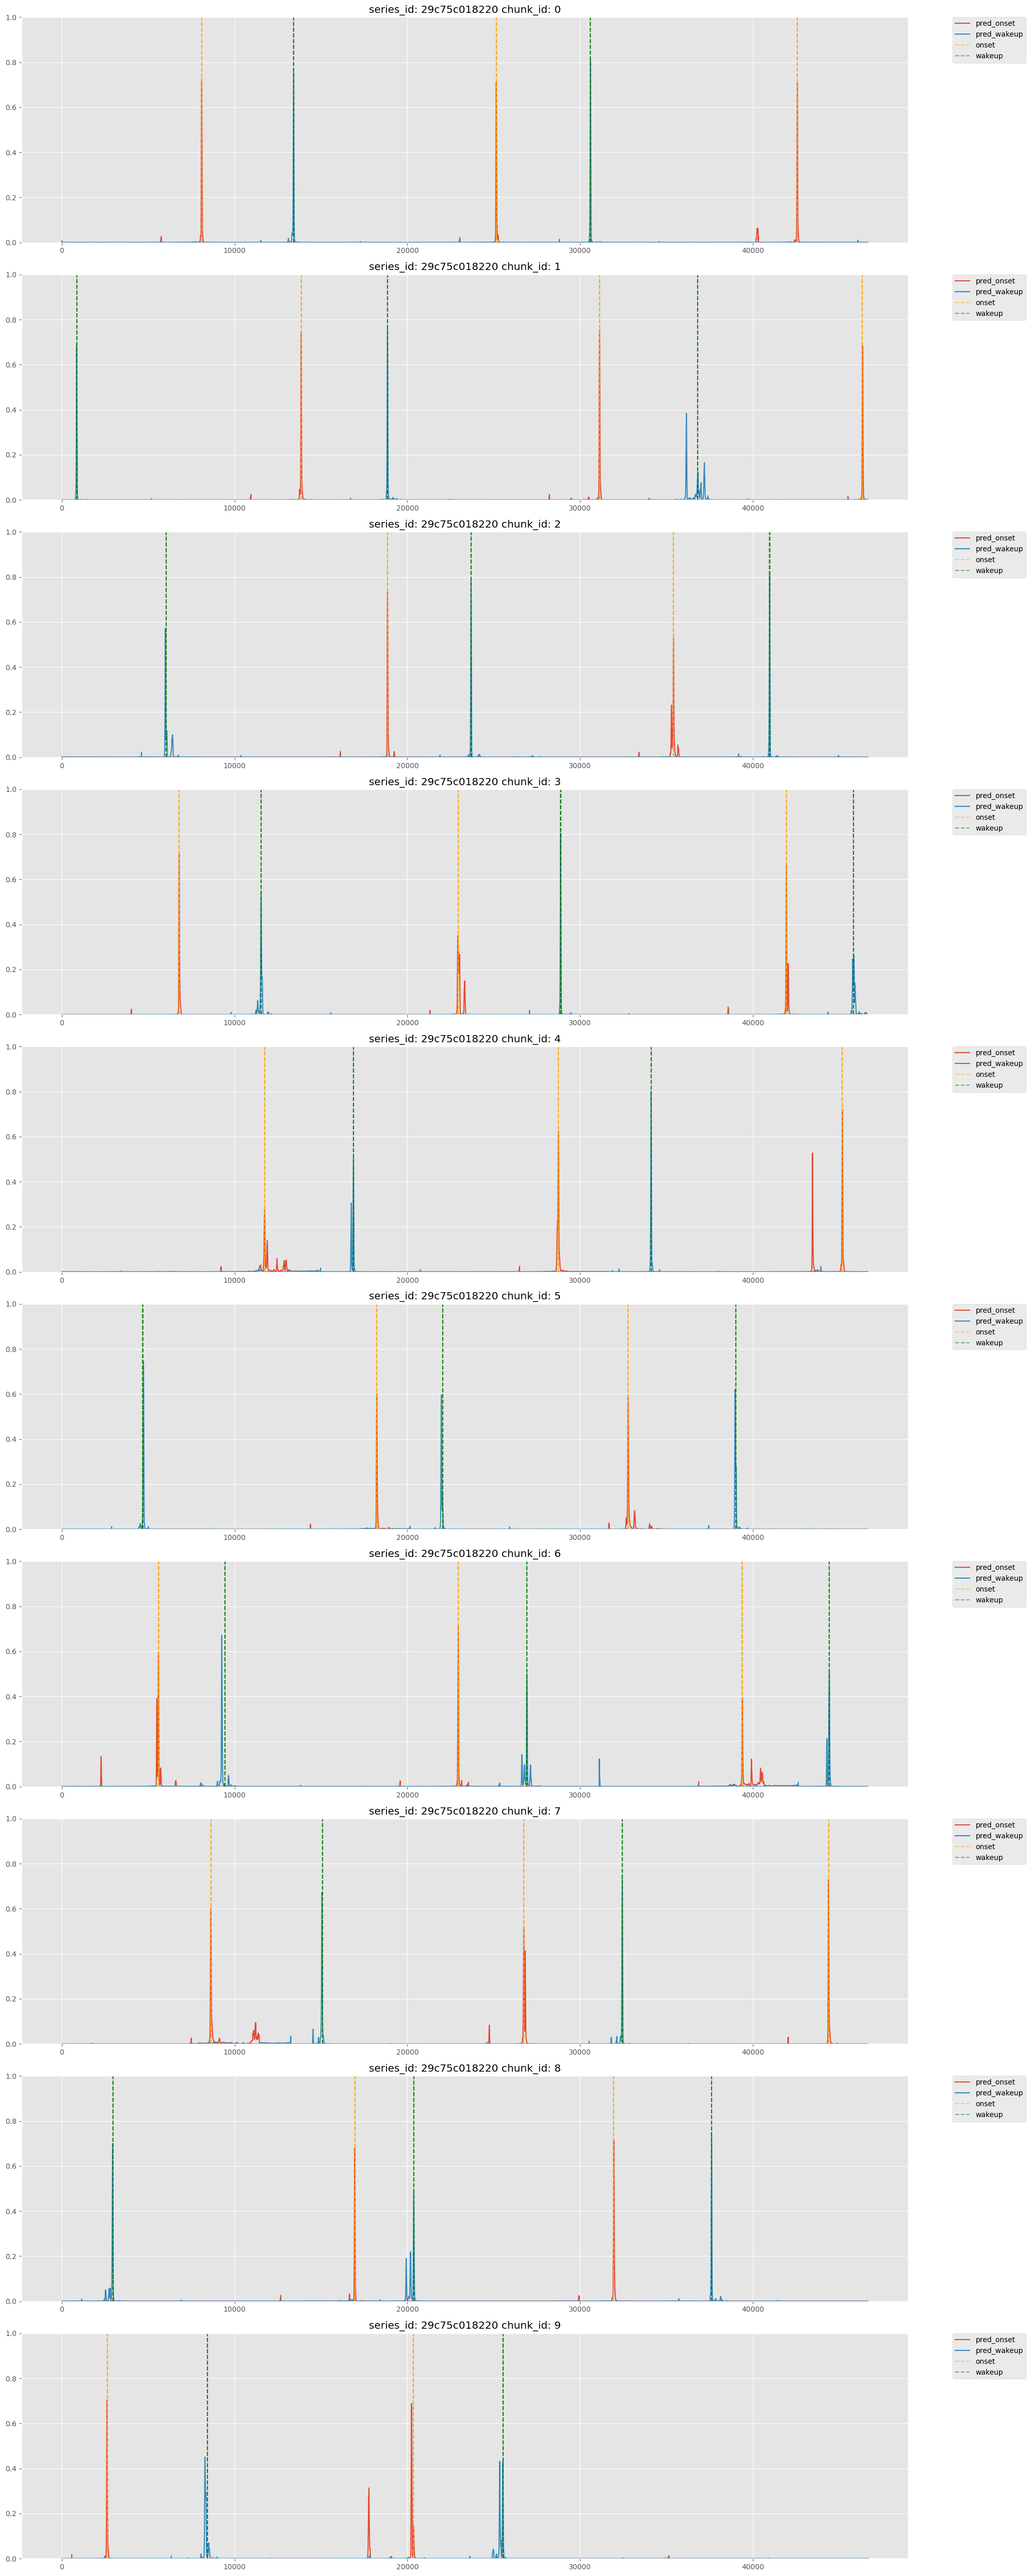

In [5]:
plot_random_sample(keys, preds, labels, num_chunks=10)